In [1]:
# These packages are not included in the MomentumED package. 
# Use the following line to add them:
# using Pkg; Pkg.add("CairoMakie"); Pkg.add("QuadGK"); Pkg.add("ClassicalOrthogonalPolynomials")

# Import the momentum-conserved exact diagonalization package
using MomentumED, LinearAlgebra
include("../Landau level disk.jl")
using .LLD

using CairoMakie # for plotting
CairoMakie.activate!()

# Plot the energy spectrum
function plot_ed_spectrum(energies, ss_m; 
    title = nothing, ylims = (nothing, nothing),
    ylabel = "Energy per unit cell (W₀ = e²/ϵl)",
)
    fig = Figure();
    ax = Axis(fig[1, 1];
        xlabel = "m",
        ylabel = ylabel
    )
    ax_top = Axis(fig[1, 1];
        xaxisposition = :top
    )
    top_ticks = ([], [])
    hidespines!(ax_top)
    hidexdecorations!(ax_top; label = false, ticklabels = false)
    hideydecorations!(ax_top)
    linkxaxes!(ax, ax_top)

    # Plot energy levels for each momentum block
    for i in 1:length(ss_m)
        x = ss_m[i]
        push!(top_ticks[1], x)
        push!(top_ticks[2], string(i))
        if isassigned(energies,i)
            for e in energies[i]
                scatter!(ax, x, e, color = :blue, marker=:hline)
            end
        end
    end
    ylims!(ax, ylims...)
    ax_top.xticks = top_ticks
    if title isa String
        ax_top.subtitle = title
    end
    display(fig)
    fig
end

plot_ed_spectrum (generic function with 1 method)

In [13]:
# Define k-mesh mimicing the angular momentum
m_list = [0 1 2 3 4 5 6 7 8 9 10 11 12 13 14;
          0 0 0 0 0 0 0 0 0 0  0  0  0  0  0]
Nm = 15
Ne = 5

m_list = [0 1 2 3 4 5 6 7 8;
          0 0 0 0 0 0 0 0 0]
Nm = 9
Ne = 3

3

In [14]:
# Set up component parameters: (layer, level, Chern number, pseudospin)
sys_int = AngularLandauInteraction((1, 0, 1, 0));

# Coulomb
sys_int.D_l = 10.0                  # Screening length D/l
# compute the pseudo-potential components
generate_Coulomb_interaction(sys_int, 2(Nm-1))
@show sys_int.V_intra_Coulomb

# Haldane pseudo-potential
sys_int.V_intra = [0.0; 1.0; 0.0; 0.01]          # Intralayer Haldane pseudo-potential in unit of W0

# choose a linear mixing between Haldane and Coulomb interaction
sys_int.mix = 0                  # mix * Haldane + (1-mix) * Coulomb

# Create parameter structure for bilayer system
para = EDPara(k_list = m_list, Gk = (0, 0), V_int = sys_int);

sys_int.V_intra_Coulomb = [1.634711735356748, 0.749358256026894, 0.5286614325145934, 0.41872976155450814, 0.3503270791671362, 0.3026827462193143, 0.2671424975972047, 0.23937933875941908, 0.21695945116067117, 0.1983956001259201, 0.18272116857187637, 0.16927717402065307, 0.1575969029479108, 0.14733935379153595, 0.13824882745122666, 0.1301293346945021, 0.12282780109628617]


In [15]:
# Create momentum blocks (Hilbert subspace) for bilayer system
subspaces, ss_m, _= ED_momentum_subspaces(para, (Ne,));
display(length(subspaces))
display(length.(subspaces) |> maximum)

# Generate Scatter lists for efficient Hamiltonian construction
scat_list1_conserve = ED_sortedScatterList_onebody(para);
scat_list2_conserve = ED_sortedScatterList_twobody(para);

19

8

In [30]:
subspaces[15]

Hilbert subspace {bits = 9, dim = 4}, dict = false
4-element Vector{MBS64{9}}:
 MBS64: 208 = 000010110 (9 bits)
 MBS64: 304 = 000011001 (9 bits)
 MBS64: 328 = 000100101 (9 bits)
 MBS64: 388 = 001000011 (9 bits)

In [12]:
Neigen = 10  # Number of eigenvalues to compute per subspace
energies = Vector{Vector{Float64}}(undef, length(subspaces));
vectors = Vector{Vector{<:MBS64Vector}}(undef, length(subspaces));
for i in eachindex(subspaces)
    println("Processing subspace #$i with size $(length(subspaces[i])), angular momentum $(ss_m[i])")
    energies[i], vectors[i] = EDsolve(subspaces[i], scat_list2_conserve, scat_list1_conserve;
        N=Neigen, showtime=true, ishermitian=true
    )
end

Processing subspace #1 with size 1, angular momentum 10


┌ Info: Hilbert space dimension < 100; switch to method=:dense automatically.
└ @ MomentumED C:\Users\zoubo\Documents\Julia\MomentumED.jl\MomentumED\src\MomentumED.jl:192


  0.524358 seconds (728.74 k allocations: 35.976 MiB, 190.47% compilation time)
  0.105938 seconds (125.78 k allocations: 6.219 MiB, 99.93% compilation time)
Processing subspace #2 with size 1, angular momentum 11
  0.000967 seconds (154 allocations: 10.203 KiB)
  0.000015 seconds (21 allocations: 1.281 KiB)
Processing subspace #3 with size 2, angular momentum 12
  0.000909 seconds (164 allocations: 12.594 KiB)
  0.000044 seconds (23 allocations: 2.578 KiB)
Processing subspace #4 with size 3, angular momentum 13
  0.001077 seconds (174 allocations: 15.234 KiB)
  0.000061 seconds (23 allocations: 3.609 KiB)
Processing subspace #5 with size 5, angular momentum 14
  0.012476 seconds (189 allocations: 21.094 KiB, 95.57% gc time)
  0.000048 seconds (24 allocations: 6.101 KiB)
Processing subspace #6 with size 7, angular momentum 15


┌ Info: Hilbert space dimension < 100; switch to method=:dense automatically.
└ @ MomentumED C:\Users\zoubo\Documents\Julia\MomentumED.jl\MomentumED\src\MomentumED.jl:192
┌ Info: Hilbert space dimension < 100; switch to method=:dense automatically.
└ @ MomentumED C:\Users\zoubo\Documents\Julia\MomentumED.jl\MomentumED\src\MomentumED.jl:192
┌ Info: Hilbert space dimension < 100; switch to method=:dense automatically.
└ @ MomentumED C:\Users\zoubo\Documents\Julia\MomentumED.jl\MomentumED\src\MomentumED.jl:192
┌ Info: Hilbert space dimension < 100; switch to method=:dense automatically.
└ @ MomentumED C:\Users\zoubo\Documents\Julia\MomentumED.jl\MomentumED\src\MomentumED.jl:192
┌ Info: Hilbert space dimension < 100; switch to method=:dense automatically.
└ @ MomentumED C:\Users\zoubo\Documents\Julia\MomentumED.jl\MomentumED\src\MomentumED.jl:192


  0.001498 seconds (200 allocations: 27.804 KiB)
  0.000037 seconds (24 allocations: 8.866 KiB)
Processing subspace #7 with size 10, angular momentum 16
  0.001951 seconds (201 allocations: 27.623 KiB)
  0.000052 seconds (24 allocations: 13.663 KiB)
Processing subspace #8 with size 13, angular momentum 17
  0.000703 seconds (223 allocations: 42.965 KiB)
  0.000050 seconds (28 allocations: 19.456 KiB)
Processing subspace #9 with size 18, angular momentum 18
  0.000904 seconds (230 allocations: 51.289 KiB)
  0.000088 seconds (28 allocations: 30.675 KiB)
Processing subspace #10 with size 23, angular momentum 19
  0.000204 seconds (231 allocations: 67.035 KiB)
  0.000194 seconds (28 allocations: 44.503 KiB)
Processing subspace #11 with size 30, angular momentum 20
  0.000202 seconds (249 allocations: 113.436 KiB)
  0.000382 seconds (29 allocations: 67.275 KiB)
Processing subspace #12 with size 36, angular momentum 21
  0.000183 seconds (267 allocations: 157.952 KiB)
  0.000188 seconds (29 

┌ Info: Hilbert space dimension < 100; switch to method=:dense automatically.
└ @ MomentumED C:\Users\zoubo\Documents\Julia\MomentumED.jl\MomentumED\src\MomentumED.jl:192
┌ Info: Hilbert space dimension < 100; switch to method=:dense automatically.
└ @ MomentumED C:\Users\zoubo\Documents\Julia\MomentumED.jl\MomentumED\src\MomentumED.jl:192
┌ Info: Hilbert space dimension < 100; switch to method=:dense automatically.
└ @ MomentumED C:\Users\zoubo\Documents\Julia\MomentumED.jl\MomentumED\src\MomentumED.jl:192
┌ Info: Hilbert space dimension < 100; switch to method=:dense automatically.
└ @ MomentumED C:\Users\zoubo\Documents\Julia\MomentumED.jl\MomentumED\src\MomentumED.jl:192
┌ Info: Hilbert space dimension < 100; switch to method=:dense automatically.
└ @ MomentumED C:\Users\zoubo\Documents\Julia\MomentumED.jl\MomentumED\src\MomentumED.jl:192
┌ Info: Hilbert space dimension < 100; switch to method=:dense automatically.
└ @ MomentumED C:\Users\zoubo\Documents\Julia\MomentumED.jl\Momentu

  3.002719 seconds (5.64 M allocations: 268.436 MiB, 4.79% gc time, 116.97% compilation time)
Processing subspace #20 with size 111, angular momentum 29
  0.000459 seconds (400 allocations: 407.800 KiB)
  0.016211 seconds (2.12 k allocations: 688.576 KiB)
Processing subspace #21 with size 121, angular momentum 30
  0.001013 seconds (403 allocations: 500.767 KiB)
  0.012847 seconds (2.39 k allocations: 837.949 KiB)
Processing subspace #22 with size 127, angular momentum 31
  0.000327 seconds (422 allocations: 494.398 KiB)
  0.003959 seconds (3.21 k allocations: 1.014 MiB)
Processing subspace #23 with size 134, angular momentum 32
  0.000539 seconds (442 allocations: 495.405 KiB)
  0.018970 seconds (2.89 k allocations: 977.695 KiB)
Processing subspace #24 with size 137, angular momentum 33
  0.001323 seconds (420 allocations: 541.501 KiB)
  0.020832 seconds (3.20 k allocations: 1.072 MiB)
Processing subspace #25 with size 141, angular momentum 34
  0.000633 seconds (416 allocations: 511.

┌ Info: Hilbert space dimension < 100; switch to method=:dense automatically.
└ @ MomentumED C:\Users\zoubo\Documents\Julia\MomentumED.jl\MomentumED\src\MomentumED.jl:192
┌ Info: Hilbert space dimension < 100; switch to method=:dense automatically.
└ @ MomentumED C:\Users\zoubo\Documents\Julia\MomentumED.jl\MomentumED\src\MomentumED.jl:192
┌ Info: Hilbert space dimension < 100; switch to method=:dense automatically.
└ @ MomentumED C:\Users\zoubo\Documents\Julia\MomentumED.jl\MomentumED\src\MomentumED.jl:192
┌ Info: Hilbert space dimension < 100; switch to method=:dense automatically.
└ @ MomentumED C:\Users\zoubo\Documents\Julia\MomentumED.jl\MomentumED\src\MomentumED.jl:192
┌ Info: Hilbert space dimension < 100; switch to method=:dense automatically.
└ @ MomentumED C:\Users\zoubo\Documents\Julia\MomentumED.jl\MomentumED\src\MomentumED.jl:192
┌ Info: Hilbert space dimension < 100; switch to method=:dense automatically.
└ @ MomentumED C:\Users\zoubo\Documents\Julia\MomentumED.jl\Momentu

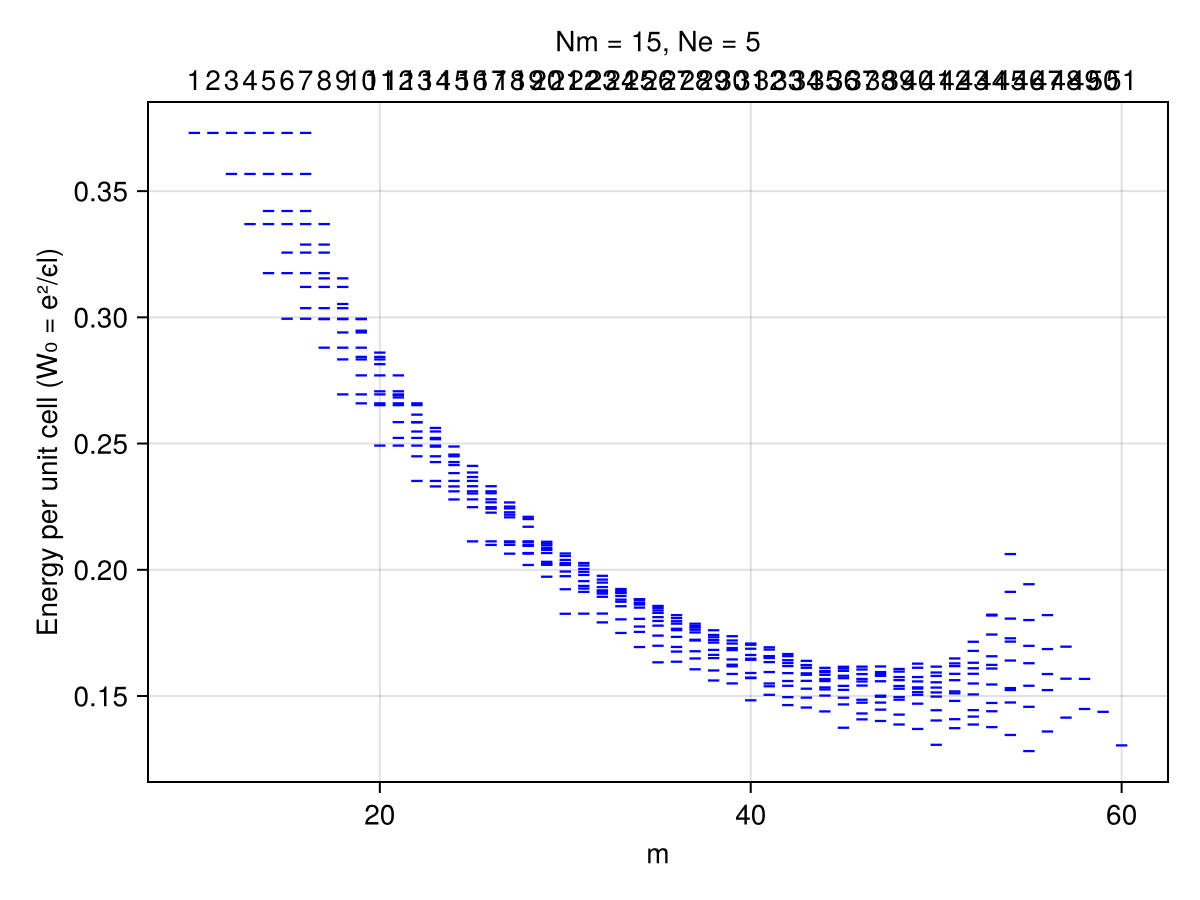

In [13]:
plot_ed_spectrum(energies/Nm/LLD.W0, ss_m,
    title = "Nm = $Nm, Ne = $Ne",
    # ylims = (0.372, 0.377),
);

In [ ]:
sn = 1 # the subspace number to inspect
println("total momentum: ", ss_k1[sn], "  ", ss_k2[sn])
energies[sn]/Nk/LLT.W0